In [47]:
import pandas as pd
import numpy as np
import os
import datetime
import sys
import seaborn as sns
import matplotlib.pyplot as plt

sys.path.append("../../../../")
from data_pipeline.score import field_names
from data_pipeline.comparison_tool.src import utils

pd.options.display.float_format = "{:,.3f}".format
%load_ext lab_black

The lab_black extension is already loaded. To reload it, use:
  %reload_ext lab_black


# Comparator definition comparison

This notebook answers a few questions:
1. How many tracts are flagged and what's the size of overlap by comparator?
2. What are the demographics of each set of tracts by "category" of score (CEJST but not comparator, comparator but not CEJST, CEJST and comparator)?
3. What are the overall demographics of ALL comparator vs ALL CEJST?

It produces a single Excel file of the stats listed, but is interactive even after run-time. This notebook focuses on 1:1 comparison. It can be pointed in the YAML to either a simple output (tract and boolean for highlight) or to the output from an ETL.

In [48]:
## These are parameters and get overridden by the "injected parameters" cell below
ADDITIONAL_DEMO_COLUMNS = []
COMPARATOR_COLUMN = None
COMPARATOR_FILE = None
DEMOGRAPHIC_COLUMNS = []
DEMOGRAPHIC_FILE = None
OUTPUT_DATA_PATH = None
SCORE_FILE = None
OTHER_COMPARATOR_COLUMNS = None
OUTPUT_NAME = None

In [125]:
# Parameters
ADDITIONAL_DEMO_COLUMNS = [
    "Urban Heuristic Flag",
    "Expected building loss rate (Natural Hazards Risk Index) (percentile)",
    "Expected agricultural loss rate (Natural Hazards Risk Index) (percentile)",
    "Expected population loss rate (Natural Hazards Risk Index) (percentile)",
    "Energy burden (percentile)",
    "PM2.5 in the air (percentile)",
    "Diesel particulate matter exposure (percentile)",
    "Traffic proximity and volume (percentile)",
    "Percent pre-1960s housing (lead paint indicator) (percentile)",
    "Housing burden (percent) (percentile)",
    "Proximity to hazardous waste sites (percentile)",
    "Proximity to NPL sites (percentile)",
    "Proximity to Risk Management Plan (RMP) facilities (percentile)",
    "Wastewater discharge (percentile)",
    "Current asthma among adults aged greater than or equal to 18 years (percentile)",
    "Low life expectancy (percentile)",
    "Diagnosed diabetes among adults aged greater than or equal to 18 years (percentile)",
    "Coronary heart disease among adults aged greater than or equal to 18 years (percentile)",
    "Low median household income as a percent of area median income (percentile)",
    "Linguistic isolation (percent) (percentile)",
    "Unemployment (percent) (percentile)",
    "Percent of individuals < 100% Federal Poverty Line (percentile)",
    "Climate Factor (Definition M)",
    "Energy Factor (Definition M)",
    "Transportation Factor (Definition M)",
    "Housing Factor (Definition M)",
    "Pollution Factor (Definition M)",
    "Water Factor (Definition M)",
    "Health Factor (Definition M)",
    "Workforce Factor (Definition M)",
]
COMPARATOR_COLUMN = "Energy-related alternative definition of communities"
COMPARATOR_FILE = "/Users/emmausds/j40/data_pipeline/data/dataset/energy_definition_alternative_draft/usa.csv"
DEMOGRAPHIC_COLUMNS = ["Median household income in the past 12 months"]
DEMOGRAPHIC_FILE = "/Users/emmausds/Desktop/justice40-tool/data/data-pipeline/data_pipeline/data/dataset/census_acs_2019/usa.csv"
GEOID_COLUMN = "GEOID10_TRACT"
OUTPUT_DATA_PATH = "/Users/emmausds/Desktop/justice40-tool/data/data-pipeline/data_pipeline/comparison_tool/output/alternative_definition"
SCORE_COLUMN = "Definition M (communities)"
SCORE_FILE = "/Users/emmausds/Desktop/justice40-tool/data/data-pipeline/data_pipeline/data/score/csv/full/usa.csv"
TOTAL_POPULATION_COLUMN = (
    "Total population in 2009 (island areas) and 2019 (states and PR)"
)
OUTPUT_NAME = "alternative_definition"

In [126]:
## These are constants for all runs
GEOID_COLUMN = field_names.GEOID_TRACT_FIELD
SCORE_COLUMN = field_names.SCORE_M_COMMUNITIES
TOTAL_POPULATION_COLUMN = field_names.TOTAL_POP_FIELD

__Date and time of last run__

In [127]:
datetime.datetime.now()

datetime.datetime(2022, 3, 16, 10, 34, 42, 66178)

__Congfigure output (autocreated)__

In [128]:
OUTPUT_EXCEL = os.path.join(
    OUTPUT_DATA_PATH,
    f"{OUTPUT_NAME}__{datetime.datetime.now().strftime('%Y-%m-%d')}.xlsx",
)

__Read in data__

In [129]:
comparator_cols = (
    [COMPARATOR_COLUMN] + OTHER_COMPARATOR_COLUMNS
    if OTHER_COMPARATOR_COLUMNS
    else [COMPARATOR_COLUMN]
)

# papermill_description=Loading_data
joined_frame = pd.concat(
    [
        utils.read_file(
            SCORE_FILE,
            columns=[TOTAL_POPULATION_COLUMN, SCORE_COLUMN] + ADDITIONAL_DEMO_COLUMNS,
            geoid=GEOID_COLUMN,
        ),
        utils.read_file(COMPARATOR_FILE, columns=comparator_cols, geoid=GEOID_COLUMN),
        utils.read_file(
            DEMOGRAPHIC_FILE,
            DEMOGRAPHIC_COLUMNS,
            geoid=GEOID_COLUMN,
        ),
    ],
    axis=1,
).reset_index()

# Comparator may provide simple list of tracts; this will fill all census tracts with "False"
joined_frame = joined_frame.fillna({COMPARATOR_COLUMN: False, SCORE_COLUMN: False})

## High-level summary

What *shares* of tracts and population highlighted by the comparator are covered by CEJST?

In [130]:
# papermill_description=Summary_stats
population = utils.produce_summary_stats(
    joined_frame, COMPARATOR_COLUMN, SCORE_COLUMN, TOTAL_POPULATION_COLUMN, GEOID_COLUMN
)
population

Population  \
Energy-related alternative definition of commun... Definition M (communities)                   
False                                              False                      217,960,904.000   
                                                   True                        47,420,786.000   
True                                               False                       14,830,058.000   
                                                   True                        46,078,223.000   

                                                                               Count of tracts  \
Energy-related alternative definition of commun... Definition M (communities)                    
False                                              False                                 47761   
                                                   True                                  12818   
True                                               False                                  2922   
                                                   True                                  10659   

                                                                               Share of tracts  \
Energy-related alternative definition of commun... Definition M (communities)                    
False                                              False                                 0.644   
                                                   True                                  0.173   
True                                               False                                 0.039   
                                                   True                                  0.144   

                                                                               Share of population  
Energy-related alternative definition of commun... Definition M (communities)                       
False                                              False                                     0.668  
                                                   True                                      0.145  
True                                               False                                     0.045  
                                                   True                                      0.141

## Tract-level stats

First, this walks through overall stats for disadvantaged communities under the comparator definition and under the CEJST's definition. Next, this walks through stats by group (e.g., CEJST and not comparator). This is at the tract level, so the average across tracts, where tracts are not population-weighted. 

In [131]:
# papermill_description=Tract_stats
tract_level_by_identification = pd.concat(
    [
        utils.get_demo_series(
            COMPARATOR_COLUMN,
            joined_frame,
            ADDITIONAL_DEMO_COLUMNS + DEMOGRAPHIC_COLUMNS,
        ),
        utils.get_demo_series(
            SCORE_COLUMN, joined_frame, ADDITIONAL_DEMO_COLUMNS + DEMOGRAPHIC_COLUMNS
        ),
    ],
    axis=1,
)

tract_level_by_identification

,Energy-related alternative definition of communities,Definition M (communities)
Urban Heuristic Flag,0.892,0.839
Expected building loss rate (Natural Hazards Risk Index) (percentile),0.476,0.503
Expected agricultural loss rate (Natural Hazards Risk Index) (percentile),0.231,0.281
Expected population loss rate (Natural Hazards Risk Index) (percentile),0.497,0.503
Energy burden (percentile),0.685,0.696
PM2.5 in the air (percentile),0.566,0.554
Diesel particulate matter exposure (percentile),0.633,0.544
Traffic proximity and volume (percentile),0.628,0.564
Percent pre-1960s housing (lead paint indicator) (percentile),0.670,0.599
Housing burden (percent) (percentile),0.761,0.714


In [132]:
graph = (
    tract_level_by_identification.sort_values(by=COMPARATOR_COLUMN, ascending=False)
    .stack()
    .reset_index()
    .rename(
        columns={"level_0": "Variable", "level_1": "Definition", 0: "Avg in tracts"}
    )
)

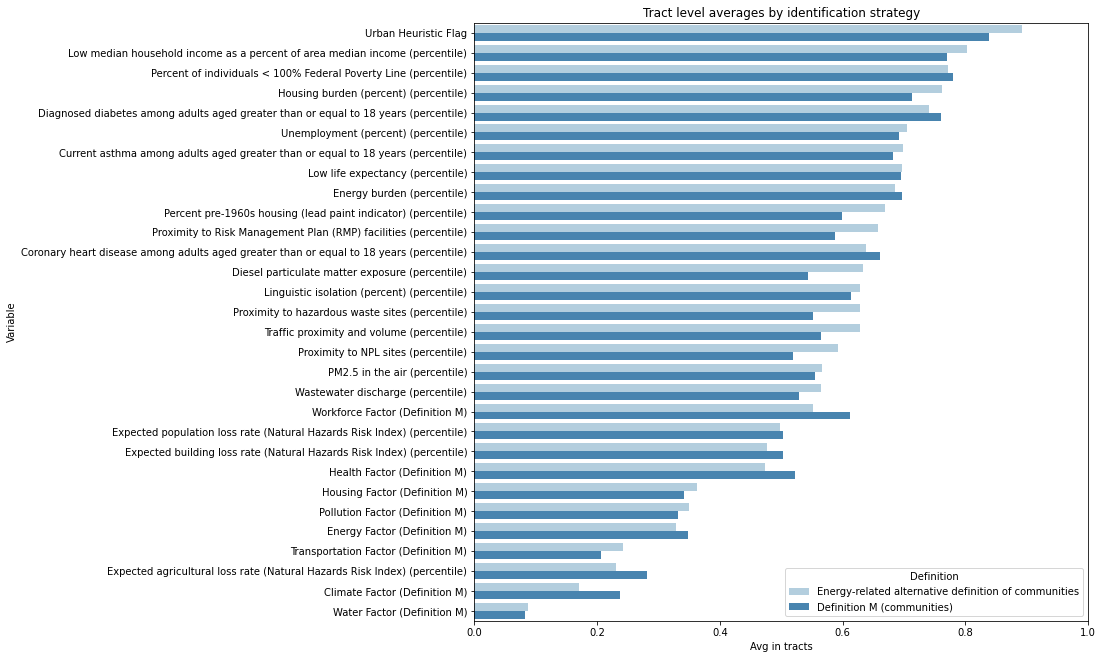

In [133]:
plt.figure(figsize=(11, 11))
sns.barplot(
    y="Variable",
    x="Avg in tracts",
    hue="Definition",
    data=graph[graph["Variable"] != "Median household income in the past 12 months"],
    palette="Blues",
)
plt.xlim(0, 1)
plt.title("Tract level averages by identification strategy")
plt.savefig(os.path.join(OUTPUT_DATA_PATH, "tract_lvl_avg.jpg"), bbox_inches="tight")

In [134]:
# papermill_description=Tract_stats_grouped
tract_level_by_grouping = utils.get_tract_level_grouping(
    joined_frame,
    SCORE_COLUMN,
    COMPARATOR_COLUMN,
    ADDITIONAL_DEMO_COLUMNS + DEMOGRAPHIC_COLUMNS,
)

tract_level_by_grouping_formatted = utils.format_multi_index_for_excel(
    tract_level_by_grouping
)

In [135]:
tract_level_by_grouping_formatted

,Variable,"Not CEJST, Comparator","CEJST, Not Comparator","CEJST, Comparator"
0,Urban Heuristic Flag,0.851,0.781,0.903
1,Expected building loss rate (Natural Hazards R...,0.481,0.528,0.475
2,Expected agricultural loss rate (Natural Hazar...,0.280,0.338,0.217
3,Expected population loss rate (Natural Hazards...,0.519,0.514,0.491
4,Energy burden (percentile),0.548,0.675,0.723
5,PM2.5 in the air (percentile),0.492,0.527,0.586
6,Diesel particulate matter exposure (percentile),0.587,0.459,0.646
7,Traffic proximity and volume (percentile),0.596,0.502,0.636
8,Percent pre-1960s housing (lead paint indicato...,0.623,0.530,0.682
9,Housing burden (percent) (percentile),0.647,0.647,0.793


## Population-weighted stats

In [136]:
# papermill_description=Population_stats
population_weighted_stats = pd.concat(
    [
        utils.construct_weighted_statistics(
            joined_frame,
            COMPARATOR_COLUMN,
            DEMOGRAPHIC_COLUMNS + ADDITIONAL_DEMO_COLUMNS,
            TOTAL_POPULATION_COLUMN,
        ),
        utils.construct_weighted_statistics(
            joined_frame,
            SCORE_COLUMN,
            DEMOGRAPHIC_COLUMNS + ADDITIONAL_DEMO_COLUMNS,
            TOTAL_POPULATION_COLUMN,
        ),
    ],
    axis=1,
)

## Print to excel

In [137]:
# papermill_description=Writing_excel
utils.write_single_comparison_excel(
    OUTPUT_EXCEL,
    population,
    tract_level_by_identification,
    population_weighted_stats,
    tract_level_by_grouping_formatted,
)

# Analysis for Anjuli

In [61]:
joined_frame.groupby([SCORE_COLUMN, COMPARATOR_COLUMN])[
    ADDITIONAL_DEMO_COLUMNS
].mean().loc[(True,)].T.tail(8)

Energy-related alternative definition of communities,False,True
Climate Factor (Definition M),0.254,0.217
Energy Factor (Definition M),0.289,0.419
Transportation Factor (Definition M),0.122,0.309
Housing Factor (Definition M),0.242,0.461
Pollution Factor (Definition M),0.238,0.446
Water Factor (Definition M),0.057,0.112
Health Factor (Definition M),0.454,0.604
Workforce Factor (Definition M),0.537,0.703


In [100]:
missing_factors = (
    joined_frame.groupby([SCORE_COLUMN, COMPARATOR_COLUMN])[ADDITIONAL_DEMO_COLUMNS]
    .sum()
    .loc[(True,)]
    .T.tail(8)
    .sort_values(by=False)
)

missing_factors

Energy-related alternative definition of communities,False,True
Water Factor (Definition M),734.000,"1,195.000"
Transportation Factor (Definition M),"1,567.000","3,292.000"
Pollution Factor (Definition M),"3,049.000","4,756.000"
Housing Factor (Definition M),"3,099.000","4,916.000"
Climate Factor (Definition M),"3,255.000","2,318.000"
Energy Factor (Definition M),"3,703.000","4,466.000"
Health Factor (Definition M),"5,813.000","6,435.000"
Workforce Factor (Definition M),"6,882.000","7,498.000"


In [106]:
missing_factors.to_csv(OUTPUT_DATA_PATH + "/missing_factors.csv")

In [65]:
score_cols = [c for c in ADDITIONAL_DEMO_COLUMNS if "percentile" in c]

In [69]:
graph_frame = (
    joined_frame.set_index([SCORE_COLUMN, COMPARATOR_COLUMN])[score_cols]
    .stack()
    .reset_index()
    .rename(columns={"level_2": "Variable", 0: "Value"})
)

In [79]:
joined_frame["group"] = (
    joined_frame[SCORE_COLUMN].astype(str)
    + "|"
    + joined_frame[COMPARATOR_COLUMN].astype(str)
)
joined_frame["group"] = joined_frame["group"].map(
    {
        "True|True": "CEJST and DOE",
        "False|True": "DOE only",
        "True|False": "CEJST only",
        "False|False": "None",
    }
)

In [140]:
state_codes

{'53': 'WA',
 '10': 'DE',
 '11': 'DC',
 '55': 'WI',
 '54': 'WV',
 '15': 'HI',
 '12': 'FL',
 '56': 'WY',
 '72': 'PR',
 '34': 'NJ',
 '35': 'NM',
 '48': 'TX',
 '22': 'LA',
 '37': 'NC',
 '38': 'ND',
 '31': 'NE',
 '47': 'TN',
 '36': 'NY',
 '42': 'PA',
 '02': 'AK',
 '32': 'NV',
 '33': 'NH',
 '51': 'VA',
 '08': 'CO',
 '06': 'CA',
 '01': 'AL',
 '05': 'AR',
 '50': 'VT',
 '17': 'IL',
 '13': 'GA',
 '18': 'IN',
 '19': 'IA',
 '25': 'MA',
 '04': 'AZ',
 '16': 'ID',
 '09': 'CT',
 '23': 'ME',
 '24': 'MD',
 '40': 'OK',
 '39': 'OH',
 '49': 'UT',
 '29': 'MO',
 '27': 'MN',
 '26': 'MI',
 '44': 'RI',
 '20': 'KS',
 '30': 'MT',
 '28': 'MS',
 '45': 'SC',
 '21': 'KY',
 '41': 'OR',
 '46': 'SD'}

In [142]:
joined_frame["state"] = (
    joined_frame[GEOID_COLUMN].str[:2].map(state_codes).fillna("other")
)
state_codes = {
    "53": "WA",
    "10": "DE",
    "11": "DC",
    "55": "WI",
    "54": "WV",
    "15": "HI",
    "12": "FL",
    "56": "WY",
    "72": "PR",
    "34": "NJ",
    "35": "NM",
    "48": "TX",
    "22": "LA",
    "37": "NC",
    "38": "ND",
    "31": "NE",
    "47": "TN",
    "36": "NY",
    "42": "PA",
    "02": "AK",
    "32": "NV",
    "33": "NH",
    "51": "VA",
    "08": "CO",
    "06": "CA",
    "01": "AL",
    "05": "AR",
    "50": "VT",
    "17": "IL",
    "13": "GA",
    "18": "IN",
    "19": "IA",
    "25": "MA",
    "04": "AZ",
    "16": "ID",
    "09": "CT",
    "23": "ME",
    "24": "MD",
    "40": "OK",
    "39": "OH",
    "49": "UT",
    "29": "MO",
    "27": "MN",
    "26": "MI",
    "44": "RI",
    "20": "KS",
    "30": "MT",
    "28": "MS",
    "45": "SC",
    "21": "KY",
    "41": "OR",
    "46": "SD",
}

In [147]:
joined_frame.groupby(["state", SCORE_COLUMN, COMPARATOR_COLUMN])[
    ADDITIONAL_DEMO_COLUMNS + DEMOGRAPHIC_COLUMNS
].mean().T.to_excel("state_level_factors.xlsx", float_format="{:.3f}")

TypeError: not all arguments converted during string formatting

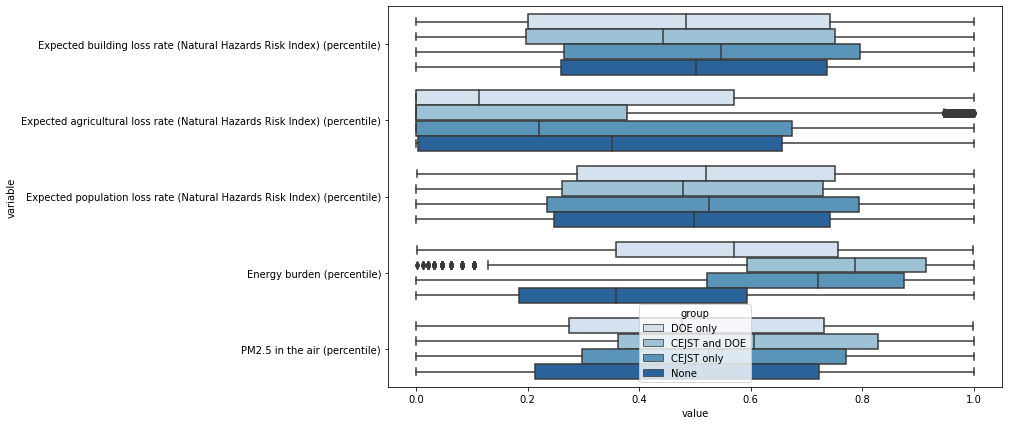

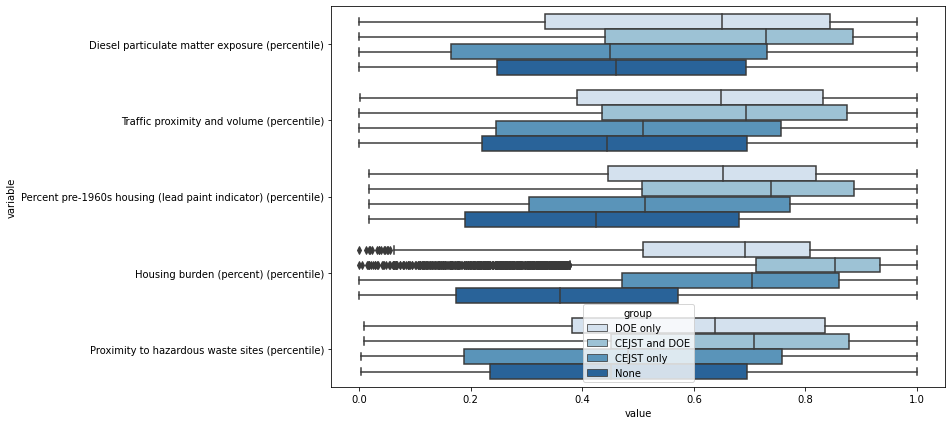

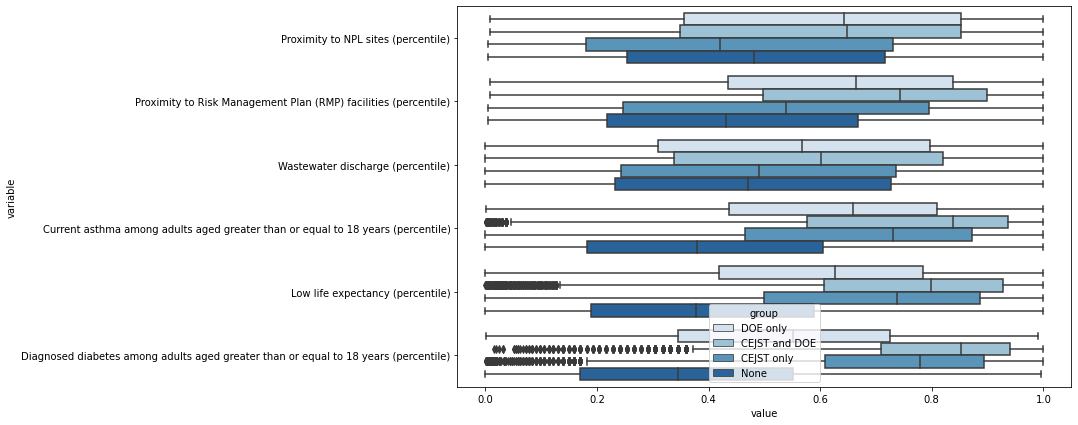

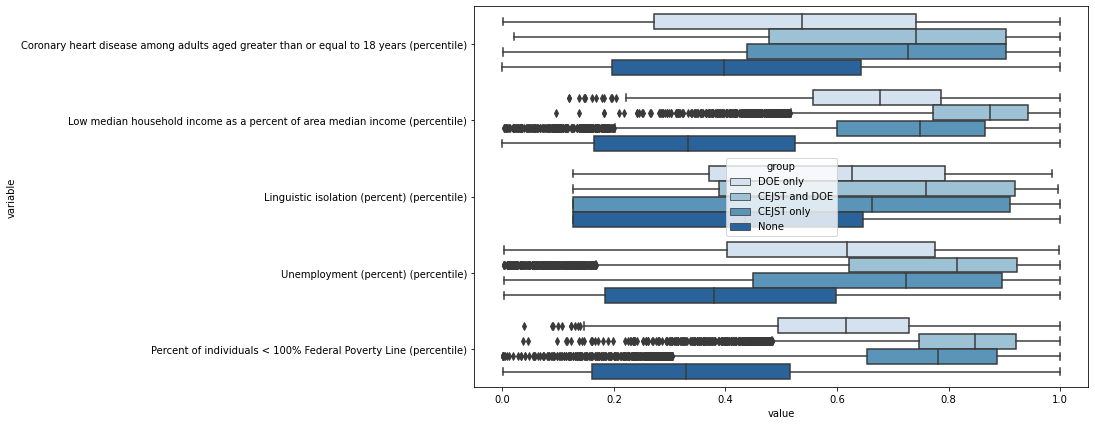

In [97]:
melted_data = pd.melt(joined_frame, id_vars="group", value_vars=score_cols)
for i, col_set in enumerate(
    [score_cols[:5], score_cols[5:10], score_cols[10:16], score_cols[16:]]
):
    plt.figure(figsize=(11, 7))
    sns.boxplot(
        x="value",
        y="variable",
        hue="group",
        data=melted_data[melted_data["variable"].isin(col_set)],
        palette="Blues",
    )
    plt.savefig(OUTPUT_DATA_PATH + f"/Anjuli_barplot_{i}.jpg", bbox_inches="tight")